<img src='https://www.unifor.br/o/unifor-theme/images/unifor-logo-horizontal.svg' width="250px">

# DATA HARVESTING / Projeto da Disciplina

Prof.: Ms. Alex Lima<br>
MBA em Ci√™ncia de Dados<br>
Universidade de Fortaleza

**Gabriela Ferreira Coutinho - 2418581**</br>

# 1. Capturando as URLs para Web Scraping

## 1.1 Instala√ß√£o e Configura√ß√£o 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

# üîπ Configura√ß√£o do Selenium para evitar bloqueios
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36")

# üîπ Inicializa o WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

print("‚úÖ Selenium configurado com sucesso!")

## 1.2 Acessar a P√°gina Principal

In [ ]:
# üîπ URL da p√°gina principal do torneio
url_base = "https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7"
driver.get(url_base)

# üîπ Espera a p√°gina carregar totalmente
WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
time.sleep(5)  # Tempo extra para garantir carregamento

print("‚úÖ P√°gina carregada com sucesso!")

## 1.3 Abrir o Dropdown e Coletar as Temporadas

In [ ]:
# üîπ Clicar no bot√£o do dropdown para abrir a lista de temporadas
try:
    dropdown_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, "DropdownButton"))
    )
    dropdown_button.click()
    time.sleep(3)  # Espera os itens carregarem
except Exception as e:
    print("üö® Erro ao abrir o dropdown das temporadas:", e)
    driver.quit()
    exit()

# üîπ Coletar os IDs das temporadas
temporadas_urls = {}

try:
    # üîπ Buscar a lista de temporadas toda vez antes de interagir
    temporadas_elements = driver.find_elements(By.XPATH, "//ul[@role='listbox']/li")
    temporadas_textos = [item.text.strip() for item in temporadas_elements]

    for nome_temporada in temporadas_textos:
        # üîπ Reabre o dropdown para garantir que ele ainda est√° dispon√≠vel
        dropdown_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "DropdownButton"))
        )
        dropdown_button.click()
        time.sleep(2)

        # üîπ Rebusca a lista de temporadas antes de clicar
        temporadas_elements = driver.find_elements(By.XPATH, "//ul[@role='listbox']/li")

        for item in temporadas_elements:
            if item.text.strip() == nome_temporada:
                item.click()  # Seleciona a temporada para carregar a p√°gina correta
                time.sleep(3)

                # üîπ Coletar o ID da URL ap√≥s a sele√ß√£o
                temporada_id = driver.current_url.split("#id:")[-1]
                url_final = f"https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7#id:{temporada_id}"
                temporadas_urls[nome_temporada] = url_final
                break

except Exception as e:
    print("üö® Erro ao coletar as temporadas:", e)

print("‚úÖ Temporadas coletadas com sucesso!")

## 1.4 Mostrar as 10 Temporadas Coletadas

In [ ]:
# üîπ Filtrar apenas as 10 √∫ltimas temporadas
temporadas_filtradas = dict(list(temporadas_urls.items())[:10])

# üîπ Exibe os IDs e URLs corrigidas
print("\nüìå Temporadas encontradas no Sofascore:")
for temporada, url in temporadas_filtradas.items():
    print(f"{temporada}: {url}")

## 1.5 Fechar o navegador 

In [ ]:
# üîπ Fechar o navegador ao fim do processo
driver.quit()
print("‚úÖ Navegador fechado com sucesso!")

## 1.6 Salvar temporadas como CSV

In [ ]:
import os
import pandas as pd

# üîπ Criar a pasta 'data' caso n√£o exista
os.makedirs("data", exist_ok=True)

# üîπ Caminho do arquivo CSV
csv_path = "data/temporadas_urls.csv"

# üîπ Converter dicion√°rio para DataFrame e salvar
df_temporadas = pd.DataFrame(list(temporadas_filtradas.items()), columns=["Temporada", "URL"])
df_temporadas.to_csv(csv_path, index=False, encoding="utf-8")

print(f"‚úÖ Temporadas salvas em {csv_path}!")

# 2. Capturar dados dos jogadores das temporadas

## 2.1 Carregar as Temporadas do CSV

In [ ]:
import pandas as pd

# üîπ Caminho do arquivo CSV salvo anteriormente
csv_path = "data/temporadas_urls.csv"

# üîπ Carregar o CSV e transformar em dicion√°rio {Temporada: URL}
df_temporadas = pd.read_csv(csv_path)
temporadas_urls = dict(zip(df_temporadas["Temporada"], df_temporadas["URL"]))

print(f"‚úÖ {len(temporadas_urls)} temporadas carregadas do CSV para scraping.")

## 2.2 Fun√ß√£o para Coletar Dados de uma Temporada

### 2.2.1 Configura√ß√£o Inicial

In [ ]:
# üîπ Importa√ß√£o das bibliotecas necess√°rias
import os
import time
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# üîπ Configura√ß√£o do Selenium para evitar bloqueios
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# üîπ Criar a pasta "data" para armazenar os resultados
os.makedirs("data", exist_ok=True)

print("‚úÖ Configura√ß√£o inicial conclu√≠da!")

‚úÖ Configura√ß√£o inicial conclu√≠da!


### 2.2.2 Carregar Temporadas do CSV

In [45]:
# üîπ Carregar as URLs das temporadas do arquivo CSV
csv_path = "data/temporadas_urls.csv"

if os.path.exists(csv_path):
    df_temporadas = pd.read_csv(csv_path)
    temporadas_urls = dict(zip(df_temporadas["Temporada"], df_temporadas["URL"]))
    print(f"‚úÖ {len(temporadas_urls)} temporadas carregadas do CSV para scraping.")
else:
    print("‚ùå Arquivo de temporadas n√£o encontrado. Execute a etapa de coleta de URLs primeiro!")

‚úÖ 10 temporadas carregadas do CSV para scraping.


### 2.2.3 Fun√ß√£o para Coletar Estat√≠sticas dos Jogadores

In [46]:
# üîπ Mapeamento das abas desejadas para coleta de estat√≠sticas
abas_desejadas = {
    "attack": "Ataque",
    "defence": "Defesa",
    "passing": "Passe",
    "goalkeeper": "Goleiro"
}

def coletar_dados_temporada(temporada, url):
    print(f"\nüîÑ Acessando temporada {temporada}: {url}")

    driver.get(url)
    time.sleep(5)

    try:
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.TAG_NAME, "table"))
        )

        for aba_id, nome_aba in abas_desejadas.items():
            print(f"\nüü° Coletando dados da aba {nome_aba}...")

            # Clicar na aba correta
            try:
                aba_botao = driver.find_element(By.XPATH, f"//button[@data-tabid='{aba_id}']")
                driver.execute_script("arguments[0].click();", aba_botao)
                time.sleep(3)
            except:
                print(f"‚ùå N√£o foi poss√≠vel acessar a aba {nome_aba}. Pulando...")
                continue

            dados_totais = []
            pagina = 1

            while True:
                print(f"üìÑ Coletando p√°gina {pagina} da aba {nome_aba}...")

                # Pegar HTML da p√°gina e processar com BeautifulSoup
                page_source = driver.page_source
                soup = BeautifulSoup(page_source, "html.parser")

                tabela = soup.find("table")
                if not tabela:
                    print(f"‚ö†Ô∏è Tabela n√£o encontrada na aba {nome_aba}.")
                    break

                # Capturar cabe√ßalhos
                cabecalhos = [th.text.strip() for th in tabela.find_all("th")]
                cabecalhos.insert(1, "Time")  # Adicionar a coluna "Time"

                # Capturar linhas da tabela
                linhas = tabela.find_all("tr")[1:]  # Ignorar cabe√ßalho
                for linha in linhas:
                    colunas = linha.find_all("td")

                    if colunas:
                        # Pega o nome do time pela imagem
                        time_element = colunas[1].find("img")
                        nome_time = time_element["alt"] if time_element else "Desconhecido"

                        # Captura os valores das colunas
                        dados_linha = [coluna.text.strip() for coluna in colunas]

                        # Capturar "Nota Sofascore" corretamente
                        try:
                            nota_sofascore = colunas[-1].find("span").text.strip()
                        except:
                            nota_sofascore = ""

                        # Adicionar a nota ao final da linha
                        dados_linha.append(nota_sofascore)

                        # Inserir o nome do time na segunda posi√ß√£o
                        dados_linha.insert(1, nome_time)

                        dados_totais.append(dados_linha)

                # Tentar clicar no bot√£o "Pr√≥xima P√°gina"
                try:
                    botao_proximo = driver.find_element(By.XPATH, "//button[@style='justify-content: flex-end;']")
                    if botao_proximo.is_enabled():
                        driver.execute_script("arguments[0].click();", botao_proximo)
                        time.sleep(3)  # Esperar carregamento
                        pagina += 1
                    else:
                        print(f"‚úÖ Todas as p√°ginas da aba {nome_aba} foram coletadas!")
                        break
                except:
                    print(f"‚úÖ √öltima p√°gina da aba {nome_aba} alcan√ßada.")
                    break

            # Criar a pasta espec√≠fica para a aba e temporada
            pasta_temporada = f"data/{nome_aba}/{temporada.replace('/', '-')}"
            os.makedirs(pasta_temporada, exist_ok=True)

            # Salvar em CSV
            if dados_totais:
                df = pd.DataFrame(dados_totais, columns=cabecalhos + ["Nota Sofascore"])
                nome_arquivo = f"{pasta_temporada}/estatisticas_jogadores.csv"
                df.to_csv(nome_arquivo, index=False, encoding="utf-8")
                print(f"‚úÖ Dados da aba {nome_aba} salvos em {nome_arquivo}")
            else:
                print(f"‚ùå Nenhum dado encontrado na aba {nome_aba}.")

    except Exception as e:
        print(f"üö® Erro ao carregar a p√°gina da temporada {temporada}: {e}")

### 2.2.4 Executar Web Scraping para Todas as Temporadas

In [47]:
# üîπ Executar a coleta de estat√≠sticas para todas as temporadas
for temporada, url in temporadas_urls.items():
    coletar_dados_temporada(temporada, url)

# üîπ Fechar o navegador ao final do processo
driver.quit()
print("‚úÖ Web scraping conclu√≠do! Navegador fechado.")


üîÑ Acessando temporada 23/24: https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7#id:52162

üü° Coletando dados da aba Ataque...
üìÑ Coletando p√°gina 1 da aba Ataque...
üìÑ Coletando p√°gina 2 da aba Ataque...
üìÑ Coletando p√°gina 3 da aba Ataque...
üìÑ Coletando p√°gina 4 da aba Ataque...
üìÑ Coletando p√°gina 5 da aba Ataque...
üìÑ Coletando p√°gina 6 da aba Ataque...
üìÑ Coletando p√°gina 7 da aba Ataque...
üìÑ Coletando p√°gina 8 da aba Ataque...
üìÑ Coletando p√°gina 9 da aba Ataque...
üìÑ Coletando p√°gina 10 da aba Ataque...
üìÑ Coletando p√°gina 11 da aba Ataque...
üìÑ Coletando p√°gina 12 da aba Ataque...
üìÑ Coletando p√°gina 13 da aba Ataque...
üìÑ Coletando p√°gina 14 da aba Ataque...
üìÑ Coletando p√°gina 15 da aba Ataque...
üìÑ Coletando p√°gina 16 da aba Ataque...
üìÑ Coletando p√°gina 17 da aba Ataque...
üìÑ Coletando p√°gina 18 da aba Ataque...
üìÑ Coletando p√°gina 19 da aba Ataque...
üìÑ Coletando p√°gina 20 da aba At

# 3. Recupera√ß√£o de informa√ß√£o

## 3.1 Limpeza dos Dados

### 3.1.1 Importa√ß√£o de bibliotecas

In [41]:
import os
import pandas as pd

### 3.1.2 Defini√ß√£o de diret√≥rios e categorias

In [42]:
# üîπ Definir o diret√≥rio base
base_dir = "data"
categorias = ["Ataque", "Defesa", "Passe", "Goleiro"]

# üîπ Criar um dicion√°rio para armazenar os DataFrames por temporada
dados_temporadas = {}

### 3.1.3 Percorrer todas as categorias e processar os dados

In [43]:
# üîπ Percorrer todas as categorias
for categoria in categorias:
    categoria_dir = os.path.join(base_dir, categoria)

    if not os.path.exists(categoria_dir):
        continue  # Se a pasta n√£o existir, pula para a pr√≥xima

    print(f"\nüîÑ Processando categoria: {categoria}")

    # üîπ Percorrer todas as temporadas dentro da categoria
    for temporada in os.listdir(categoria_dir):
        temporada_dir = os.path.join(categoria_dir, temporada)
        arquivo_csv = os.path.join(temporada_dir, "estatisticas_jogadores.csv")

        if not os.path.exists(arquivo_csv):
            continue  # Se o arquivo n√£o existir, pula para a pr√≥xima

        print(f"üìÇ Carregando {arquivo_csv}")

        # üîπ Carregar o CSV
        df = pd.read_csv(arquivo_csv)

        # üîπ Corrigir nome da coluna "Time" (se existir)
        if "Time" in df.columns:
            df.rename(columns={"Time": "Clube"}, inplace=True)  # Substitui "Time" por "Clube"

        # üîπ Remover colunas vazias ou n√£o utilizadas
        df.dropna(how="all", axis=1, inplace=True)  # Remove colunas completamente vazias

        # üîπ Remover colunas duplicadas
        df = df.loc[:, ~df.columns.duplicated()]
        
        # üîπ Tratar valores ausentes sem usar inplace=True
        for col in df.columns:
            if df[col].dtype == "object":  
                df[col] = df[col].fillna("N/A")  # Para colunas de texto, substituir por "N/A"
            else:
                df[col] = df[col].fillna(0.0)  # Para colunas num√©ricas, substituir por 0.0

        # üîπ Adicionar categoria ao DataFrame
        df["Categoria"] = categoria  

        # üîπ Criar DataFrame para a temporada caso ainda n√£o exista
        if temporada not in dados_temporadas:
            dados_temporadas[temporada] = df
        else:
            # üîπ Concatenar com os dados j√° existentes para aquela temporada
            dados_temporadas[temporada] = pd.concat([dados_temporadas[temporada], df], ignore_index=True)


üîÑ Processando categoria: Ataque
üìÇ Carregando data/Ataque/20-21/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/15-16/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/22-23/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/23-24/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/14-15/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/18-19/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/21-22/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/19-20/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/16-17/estatisticas_jogadores.csv
üìÇ Carregando data/Ataque/17-18/estatisticas_jogadores.csv

üîÑ Processando categoria: Defesa
üìÇ Carregando data/Defesa/20-21/estatisticas_jogadores.csv
üìÇ Carregando data/Defesa/15-16/estatisticas_jogadores.csv
üìÇ Carregando data/Defesa/22-23/estatisticas_jogadores.csv
üìÇ Carregando data/Defesa/23-24/estatisticas_jogadores.csv
üìÇ Carregando data/Defesa/14-15/estatisticas_jogadores.csv
üìÇ Carregan

### 3.1.4 Criar diret√≥rio para salvar os arquivos unificados

In [44]:
# üîπ Criar pasta para os arquivos unificados
output_dir = "data_unificada"
os.makedirs(output_dir, exist_ok=True)

### 3.1.5 Salvar os dados unificados por temporada

In [45]:
# üîπ Salvar cada temporada como um √∫nico CSV
for temporada, df in dados_temporadas.items():
    output_file = os.path.join(output_dir, f"estatisticas_{temporada}.csv")
    df.to_csv(output_file, index=False, encoding="utf-8")
    print(f"‚úÖ Temporada {temporada} limpa, unificada e salva em {output_file}")

print("\nüéØ üîπ Processamento conclu√≠do! Todos os dados foram limpos e unificados.")

‚úÖ Temporada 20-21 limpa, unificada e salva em data_unificada/estatisticas_20-21.csv
‚úÖ Temporada 15-16 limpa, unificada e salva em data_unificada/estatisticas_15-16.csv
‚úÖ Temporada 22-23 limpa, unificada e salva em data_unificada/estatisticas_22-23.csv
‚úÖ Temporada 23-24 limpa, unificada e salva em data_unificada/estatisticas_23-24.csv
‚úÖ Temporada 14-15 limpa, unificada e salva em data_unificada/estatisticas_14-15.csv
‚úÖ Temporada 18-19 limpa, unificada e salva em data_unificada/estatisticas_18-19.csv
‚úÖ Temporada 21-22 limpa, unificada e salva em data_unificada/estatisticas_21-22.csv
‚úÖ Temporada 19-20 limpa, unificada e salva em data_unificada/estatisticas_19-20.csv
‚úÖ Temporada 16-17 limpa, unificada e salva em data_unificada/estatisticas_16-17.csv
‚úÖ Temporada 17-18 limpa, unificada e salva em data_unificada/estatisticas_17-18.csv

üéØ üîπ Processamento conclu√≠do! Todos os dados foram limpos e unificados.


### 3.1.6 Criar um Dicion√°rio de Colunas por Categoria

In [46]:
# üîπ Criar um dicion√°rio fixo para definir as colunas relevantes por categoria
colunas_por_categoria = {
    "Ataque": [
        "Nome", "Clube", "Gols", "Gols esperados (xG)", "Grandes chances perdidases", 
        "Dribles certos", "Finaliza√ß√µes", "Convers√£o de gols %", "Nota Sofascore"
    ],
    "Defesa": [
        "Nome", "Clube", "Desarmes", "Intercepta√ß√µes", "Cortes", 
        "Erros que levaram ao gol", "Nota Sofascore"
    ],
    "Passe": [
        "Nome", "Clube", "Grandes chances criadas", "Assist√™ncias", 
        "Passes certos", "Passes certos %", "Passes decisivos", "Nota Sofascore"
    ],
    "Goleiro": [
        "Nome", "Clube", "Defesas", "P√™nalti defendido", "Jogos sem ser vazado", 
        "Defesas de dentro da √°rea", "Sa√≠das do gol", "Nota Sofascore"
    ]
}

print("‚úÖ Dicion√°rio de colunas por categoria criado!")

‚úÖ Dicion√°rio de colunas por categoria criado!


### 3.1.7 Definir diret√≥rio de dados

In [47]:
import os
import pandas as pd

# üîπ Diret√≥rio onde est√£o os CSVs unificados
output_dir = "data_unificada"

print(f"üìÇ Diret√≥rio de sa√≠da definido: {output_dir}")

üìÇ Diret√≥rio de sa√≠da definido: data_unificada


### 3.1.8 Aplicar Filtro de Colunas em Cada CSV

In [49]:
# üîπ Processar cada arquivo CSV unificado por temporada
for arquivo in os.listdir(output_dir):
    if not arquivo.endswith(".csv"):
        continue

    caminho_arquivo = os.path.join(output_dir, arquivo)
    print(f"\nüìÇ Ajustando {caminho_arquivo}")

    # üîπ Carregar CSV
    df = pd.read_csv(caminho_arquivo)

    # üîπ Criar uma c√≥pia do DataFrame para evitar problemas com √≠ndices
    df_filtrado = df.copy()

    # üîπ Manter apenas as colunas relevantes para cada categoria
    for categoria, colunas in colunas_por_categoria.items():
        df_categoria = df["Categoria"] == categoria  # Filtrar linhas dessa categoria

        # üîπ Verificar quais colunas existem no DataFrame antes de aplicar
        colunas_existentes = [col for col in colunas if col in df.columns]

        # üîπ Reduzir o DataFrame para conter apenas as colunas certas
        df_filtrado.loc[df_categoria, colunas_existentes] = df.loc[df_categoria, colunas_existentes]

    # üîπ Salvar o arquivo atualizado
    df_filtrado.to_csv(caminho_arquivo, index=False, encoding="utf-8")
    print(f"‚úÖ Ajustado e salvo: {caminho_arquivo}")

print("\nüéØ üîπ Processamento conclu√≠do! Apenas colunas relevantes foram mantidas para cada categoria.")


üìÇ Ajustando data_unificada/estatisticas_16-17.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_16-17.csv

üìÇ Ajustando data_unificada/estatisticas_14-15.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_14-15.csv

üìÇ Ajustando data_unificada/estatisticas_23-24.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_23-24.csv

üìÇ Ajustando data_unificada/estatisticas_21-22.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_21-22.csv

üìÇ Ajustando data_unificada/estatisticas_19-20.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_19-20.csv

üìÇ Ajustando data_unificada/estatisticas_17-18.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_17-18.csv

üìÇ Ajustando data_unificada/estatisticas_15-16.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_15-16.csv

üìÇ Ajustando data_unificada/estatisticas_20-21.csv
‚úÖ Ajustado e salvo: data_unificada/estatisticas_20-21.csv

üìÇ Ajustando data_unificada/estatisticas_18-19.csv
‚úÖ Ajustado e salvo: data_unifica

Se "Gols esperados (xG)" n√£o estiver presente em uma temporada, o c√≥digo n√£o tentar√° for√ßar sua inclus√£o.  
‚úÖ **Cria√ß√£o de uma c√≥pia do DataFrame** ‚Üí Isso previne problemas com √≠ndices ao manipular os dados.  
‚úÖ **Maior seguran√ßa na filtragem** ‚Üí Garantimos que cada categoria tenha apenas os dados relevantes.  

## 3.2 An√°lise

### 3.2.1 Importar Bibliotecas e Configurar Estilo dos Gr√°ficos

In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Configura√ß√£o de estilo
plt.style.use("ggplot")

### 3.2.2 Carregar os arquivos CSV unificados

In [57]:
# Definir diret√≥rio onde est√£o os dados unificados
output_dir = "data_unificada"

# Lista para armazenar os DataFrames de cada temporada
dfs = []

# Percorrer os arquivos e carregar os dados
for arquivo in os.listdir(output_dir):
    if arquivo.endswith(".csv"):
        temporada = arquivo.replace("estatisticas_", "").replace(".csv", "")
        df = pd.read_csv(os.path.join(output_dir, arquivo))
        df["Temporada"] = temporada  # Adicionar a temporada ao DataFrame
        dfs.append(df)

# Concatenar todos os DataFrames em um √∫nico
df_geral = pd.concat(dfs, ignore_index=True)

print(f"‚úÖ Dados carregados com sucesso! {df_geral.shape[0]} registros no total.")

‚úÖ Dados carregados com sucesso! 22642 registros no total.


### 3.2.3 Tend√™ncia de Desempenho ao Longo das Temporadas

#### N√∫mero de Gols

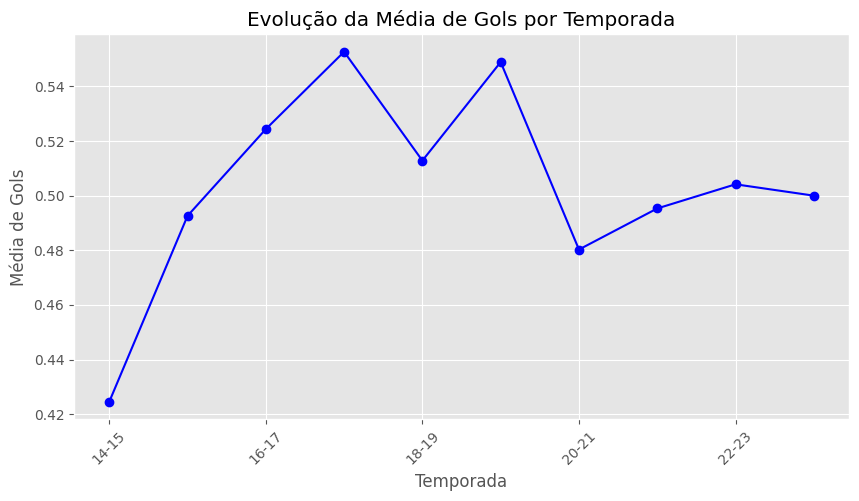

In [58]:
# Agrupar por temporada e calcular a m√©dia de gols
df_gols = df_geral.groupby("Temporada")["Gols"].mean()

# Criar o gr√°fico de evolu√ß√£o dos gols
plt.figure(figsize=(10, 5))
df_gols.plot(marker="o", color="b")
plt.title("Evolu√ß√£o da M√©dia de Gols por Temporada")
plt.xlabel("Temporada")
plt.ylabel("M√©dia de Gols")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Assist√™ncias

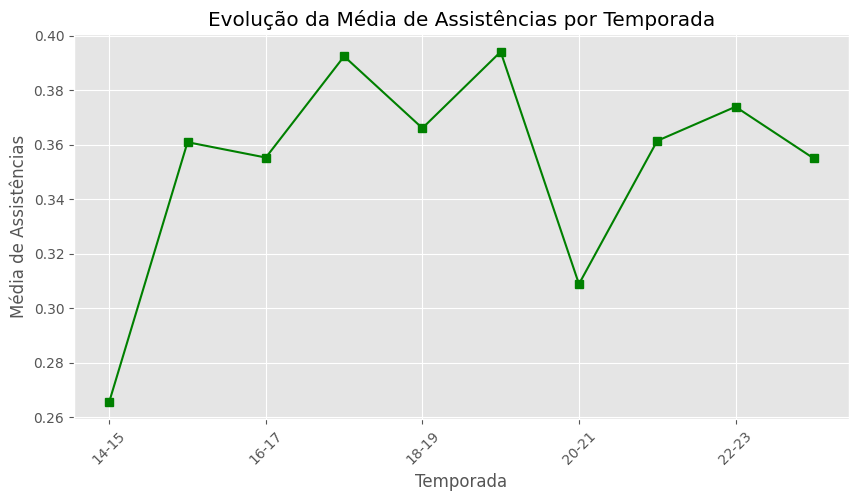

In [59]:
# Agrupar por temporada e calcular a m√©dia de assist√™ncias
df_assistencias = df_geral.groupby("Temporada")["Assist√™ncias"].mean()

# Criar o gr√°fico de evolu√ß√£o das assist√™ncias
plt.figure(figsize=(10, 5))
df_assistencias.plot(marker="s", color="g")
plt.title("Evolu√ß√£o da M√©dia de Assist√™ncias por Temporada")
plt.xlabel("Temporada")
plt.ylabel("M√©dia de Assist√™ncias")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Defesas de Goleiros

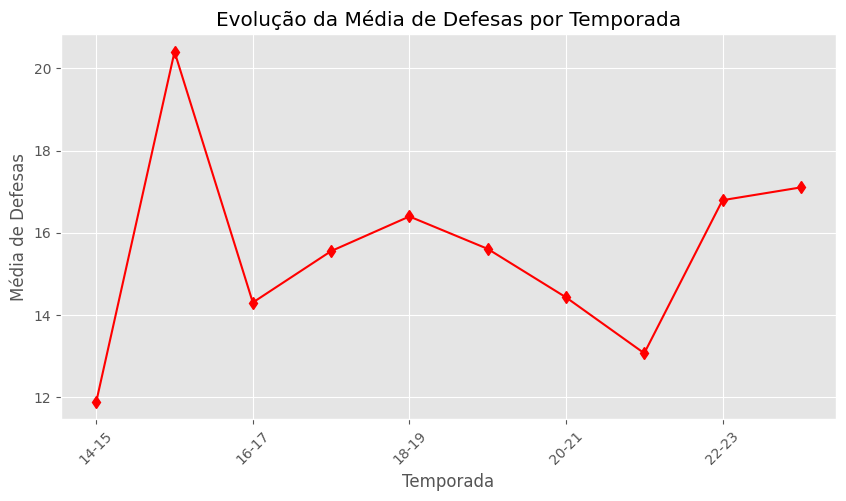

In [60]:
# Filtrar apenas os goleiros
df_goleiros = df_geral[df_geral["Categoria"] == "Goleiro"]

# Agrupar por temporada e calcular a m√©dia de defesas
df_defesas = df_goleiros.groupby("Temporada")["Defesas"].mean()

# Criar o gr√°fico de evolu√ß√£o das defesas
plt.figure(figsize=(10, 5))
df_defesas.plot(marker="d", color="r")
plt.title("Evolu√ß√£o da M√©dia de Defesas por Temporada")
plt.xlabel("Temporada")
plt.ylabel("M√©dia de Defesas")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Clubes com Melhor Desempenho ao Longo das Temporadas

In [61]:
# Agrupar por clube e temporada, calculando a m√©dia da Nota Sofascore
df_clubes = df_geral.groupby(["Temporada", "Clube"])["Nota Sofascore"].mean().reset_index()

# Ordenar por temporada e nota
df_clubes_top = df_clubes.sort_values(["Temporada", "Nota Sofascore"], ascending=[True, False])

# Exibir os 10 melhores clubes de cada temporada
for temporada in df_clubes_top["Temporada"].unique():
    print(f"\nTop Clubes na Temporada {temporada}")
    display(df_clubes_top[df_clubes_top["Temporada"] == temporada].head(10))


Top Clubes na Temporada 14-15


Temporada                Clube  Nota Sofascore
40     14-15          Real Madrid        7.298873
7      14-15            Barcelona        7.169552
5      14-15      Atl√©tico Madrid        7.092535
18     14-15             FC Porto        7.009014
11     14-15    Borussia Dortmund        7.004459
3      14-15              Arsenal        6.938778
33     14-15      Manchester City        6.911803
43     14-15     Shakhtar Donetsk        6.889672
29     14-15            Liverpool        6.870781
9      14-15  Bayer 04 Leverkusen        6.859687


Top Clubes na Temporada 15-16


Temporada                Clube  Nota Sofascore
75     15-16          Real Madrid        7.200882
61     15-16    FC Bayern M√ºnchen        7.155493
54     15-16            Barcelona        7.060137
52     15-16      Atl√©tico Madrid        7.049857
59     15-16              Chelsea        6.999077
62     15-16             FC Porto        6.938364
72     15-16   Olympique Lyonnais        6.925000
50     15-16              Arsenal        6.898108
55     15-16  Bayer 04 Leverkusen        6.889818
69     15-16      Manchester City        6.889706


Top Clubes na Temporada 16-17


Temporada                Clube  Nota Sofascore
96      16-17    FC Bayern M√ºnchen        7.025538
110     16-17          Real Madrid        7.014225
107     16-17   Olympique Lyonnais        7.005469
111     16-17              Sevilla        6.981343
83      16-17              Arsenal        6.970469
113     16-17    Tottenham Hotspur        6.942031
84      16-17      Atl√©tico Madrid        6.941290
101     16-17             Juventus        6.933506
87      16-17  Bayer 04 Leverkusen        6.906250
85      16-17            Barcelona        6.901690


Top Clubes na Temporada 17-18


Temporada                Clube  Nota Sofascore
132     17-18    Manchester United        7.098571
125     17-18    FC Bayern M√ºnchen        7.086176
136     17-18  Paris Saint-Germain        7.070690
140     17-18          Real Madrid        7.037042
130     17-18            Liverpool        7.015342
117     17-18            Barcelona        7.008088
131     17-18      Manchester City        6.986234
142     17-18              Sevilla        6.950735
116     17-18      Atl√©tico Madrid        6.929508
141     17-18                 Roma        6.912459


Top Clubes na Temporada 18-19


Temporada                Clube  Nota Sofascore
170     18-19          Real Madrid        7.090135
164     18-19      Manchester City        7.081563
150     18-19            Barcelona        7.059324
155     18-19    FC Bayern M√ºnchen        6.959836
162     18-19            Liverpool        6.919344
161     18-19             Juventus        6.909104
166     18-19               Napoli        6.894364
147     18-19             AFC Ajax        6.894328
171     18-19                 Roma        6.892432
169     18-19  Paris Saint-Germain        6.884516


Top Clubes na Temporada 19-20


Temporada                 Clube  Nota Sofascore
201     19-20   Paris Saint-Germain        7.057297
181     19-20             Barcelona        7.052297
197     19-20       Manchester City        7.000735
195     19-20             Liverpool        6.955968
180     19-20       Atl√©tico Madrid        6.916563
203     19-20           Real Madrid        6.909054
191     19-20                 Inter        6.897069
187     19-20     FC Bayern M√ºnchen        6.874426
209     19-20  Zenit St. Petersburg        6.860169
202     19-20            RB Leipzig        6.830270


Top Clubes na Temporada 20-21


Temporada                Clube  Nota Sofascore
226     20-21             Juventus        7.075735
230     20-21      Manchester City        7.020909
217     20-21              Chelsea        7.020000
220     20-21    FC Bayern M√ºnchen        6.964625
228     20-21            Liverpool        6.964333
213     20-21            Barcelona        6.944940
236     20-21          Real Madrid        6.923289
215     20-21    Borussia Dortmund        6.869875
234     20-21  Paris Saint-Germain        6.869000
212     20-21      Atl√©tico Madrid        6.843115


Top Clubes na Temporada 21-22


Temporada                Clube  Nota Sofascore
252     21-22    FC Bayern M√ºnchen        7.098243
249     21-22              Chelsea        6.980270
259     21-22      Manchester City        6.957037
242     21-22             AFC Ajax        6.916615
262     21-22  Paris Saint-Germain        6.914923
254     21-22                Inter        6.878143
260     21-22    Manchester United        6.820312
243     21-22             Atalanta        6.786230
266     21-22              Sevilla        6.777761
263     21-22           RB Leipzig        6.771324


Top Clubes na Temporada 22-23


Temporada              Clube  Nota Sofascore
292     22-23    Manchester City        7.105735
284     22-23  FC Bayern M√ºnchen        7.094359
294     22-23             Napoli        7.025075
299     22-23        Real Madrid        6.950882
290     22-23          Liverpool        6.903947
276     22-23          Barcelona        6.892750
304     22-23  Tottenham Hotspur        6.892338
281     22-23            Chelsea        6.885875
279     22-23  Borussia Dortmund        6.871375
288     22-23              Inter        6.871343


Top Clubes na Temporada 23-24


Temporada                Clube  Nota Sofascore
330     23-24          Real Madrid        7.142500
313     23-24    FC Bayern M√ºnchen        7.029054
311     23-24    Borussia Dortmund        7.008028
327     23-24  Paris Saint-Germain        6.992031
309     23-24            Barcelona        6.977922
321     23-24      Manchester City        6.946364
328     23-24           RB Leipzig        6.937887
307     23-24              Arsenal        6.934789
319     23-24                Inter        6.922500
315     23-24             FC Porto        6.867763